# nexflow SLAMseq test - MYB dTAG

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [2]:
import os
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np
from natsort import os_sorted

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

## save reference file to ccle bucket

In [9]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [10]:
# google storage bucket with reference files
! gsutil -m cp $refgenome_noAlt gs://ccle_default_params/

Copying file://../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 403 858557604497-compute@developer.gserviceaccount.com does not have storage.objects.create access to the Google Cloud Storage object.
CommandException: 1 file/object could

In [11]:
! gsutil ls gs://ccle_default_params/

gs://ccle_default_params/1000g_pon.hg38.vcf.gz
gs://ccle_default_params/1000g_pon.hg38.vcf.gz.tbi
gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.dict
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapi

# nextflow SLAMseq

using 2 DMSO samples and 2 VHL samples from MYB_degraded_v1 dataset

In [4]:
project = "nextflow_slamseq_MYB"
test_data_proj = "MYB_degraded_v1"

### download the data

In [2]:
location = "../data/"+project+"/" # new data location
loc = "210722_MP9119_fastq" # transfer AML folder

In [3]:
! mkdir ../$location
! mkdir ../results/$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

In [11]:
fastq = ! gsutil ls gs://transfer-amlproject/$loc/*.fastq.gz

for f in fastq:
    print(os.path.basename(f))

20210722_10_MP9119_S95_R1_001.fastq.gz
20210722_10_MP9119_S95_R2_001.fastq.gz
20210722_11_MP9119_S96_R1_001.fastq.gz
20210722_11_MP9119_S96_R2_001.fastq.gz
20210722_12_MP9119_S97_R1_001.fastq.gz
20210722_12_MP9119_S97_R2_001.fastq.gz
20210722_1_MP9119_S86_R1_001.fastq.gz
20210722_1_MP9119_S86_R2_001.fastq.gz
20210722_2_MP9119_S87_R1_001.fastq.gz
20210722_2_MP9119_S87_R2_001.fastq.gz
20210722_3_MP9119_S88_R1_001.fastq.gz
20210722_3_MP9119_S88_R2_001.fastq.gz
20210722_4_MP9119_S89_R1_001.fastq.gz
20210722_4_MP9119_S89_R2_001.fastq.gz
20210722_5_MP9119_S90_R1_001.fastq.gz
20210722_5_MP9119_S90_R2_001.fastq.gz
20210722_6_MP9119_S91_R1_001.fastq.gz
20210722_6_MP9119_S91_R2_001.fastq.gz
20210722_7_MP9119_S92_R1_001.fastq.gz
20210722_7_MP9119_S92_R2_001.fastq.gz
20210722_8_MP9119_S93_R1_001.fastq.gz
20210722_8_MP9119_S93_R2_001.fastq.gz
20210722_9_MP9119_S94_R1_001.fastq.gz
20210722_9_MP9119_S94_R2_001.fastq.gz


In [12]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

Copying gs://transfer-amlproject/210722_MP9119_fastq/multiqc_report.html...
/ [1/1 files][  1.3 MiB/  1.3 MiB] 100% Done                                    
Operation completed over 1 objects/1.3 MiB.                                      
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R2_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R2_001_fastqc.html...
Copying gs://transfer-

In [20]:
# download fastqs from bucket
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/

Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_3_MP9119_S88_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_5_MP9119_S90_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s

### rename local fastqs

In [23]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
os_sorted(fastqs[::2])

../../data/nextflow_slamseq_MYB/fastqs


['20210722_1_MP9119_S86_R1_001.fastq.gz',
 '20210722_2_MP9119_S87_R1_001.fastq.gz',
 '20210722_3_MP9119_S88_R1_001.fastq.gz',
 '20210722_4_MP9119_S89_R1_001.fastq.gz',
 '20210722_5_MP9119_S90_R1_001.fastq.gz',
 '20210722_6_MP9119_S91_R1_001.fastq.gz',
 '20210722_7_MP9119_S92_R1_001.fastq.gz',
 '20210722_8_MP9119_S93_R1_001.fastq.gz',
 '20210722_9_MP9119_S94_R1_001.fastq.gz',
 '20210722_10_MP9119_S95_R1_001.fastq.gz',
 '20210722_11_MP9119_S96_R1_001.fastq.gz',
 '20210722_12_MP9119_S97_R1_001.fastq.gz']

In [14]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [15]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == test_data_proj] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
#sample_info.head()

In [28]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

In [31]:
# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

In [36]:
fastqs = ! ls $fastq_folder
fastqs

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 'mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_R2_001.fastq.gz',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz']

# SLAMseq analysis

In [5]:
project = "nextflow_slamseq_MYB"

In [7]:
fastq_folder = "../../data/"+project+"/fastqs"
fastqs = ! ls $fastq_folder/*fastq.gz
fastqs[:5]

['../../data/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 '../../data/nextflow_slamseq_MYB/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/nextflow_slamseq_MYB/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 '../../data/nextflow_slamseq_MYB/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz']

In [8]:
project

'nextflow_slamseq_MYB'

In [40]:
! gsutil -m cp $fastq_folder/* gs://amlproject/RNA/slamseq/$project/fastqs/ 

Copying file://../../data/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../dat

## design matrix

In [41]:
fastqs = ! gsutil ls gs://amlproject/RNA/slamseq/$project/fastqs/ 

In [44]:
fastqs

['gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R2_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr366-MV411-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz',
 'gs://amlproject/RNA/slamseq/nextflow_slamseq_MYB/fastqs/mr366-MV411-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz']

In [43]:
[os.path.basename(f) for f in fastqs]

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 'mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_R2_001.fastq.gz',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz']

In [59]:
gsheet[gsheet['batch'] == test_data_proj]

,ID,cell line,type,condition,replicate,batch,name,prev_name,fastq1,fastq2,prefix,count folder,fastqc folder,fastq folder
358,mr359,MV411-MYB-dTAG,SLAM,DMSO_1h,1,MYB_degraded_v1,mr359-MV411-MYB-dTAG-DMSO_1h-r1,20210722_1_MP9119_S86,NaN,NaN,NaN,https://console.cloud.google.com/storage/brows...,NaN,https://console.cloud.google.com/storage/brows...


In [16]:
# design matrix
df = {
    "group": [],
    "condition": [],
    #"replicate": [],
    "control": [],
    "reads": [],
    "reads2": [],
    "name": []
}

In [17]:
for val in h.grouped(fastqs, 2):
    row = gsheet[gsheet.ID==val[0].split('/')[-1].split('-')[0]]
    df['group'].append(row["cell line"].item())
    df['condition'].append(row["condition"].item())
    #df['replicate'].append(row["replicate"].item())
    df['control'].append([1 if "DMSO" in row["condition"].item() else 0][0])
    df['reads'].append(val[0])
    df['reads2'].append(val[1])
    df['name'].append(row["name"].item())
    
    #print(row["ID"].item())
    #print("group: {}".format(row["cell line"].item()))
    #print("condition: {}".format(row["condition"].item()))
    #print("replicate: {}".format(row["replicate"].item()))
    #print("control: {}".format([1 if "DMSO" in row["condition"].item() else 0][0]))
    #print("reads: {}".format(val[0]))
    #print("reads2: {}".format(val[1]))
    #print("name: {}".format(row["ID"].item()+"-"+row["cell line"].item()+"-"+row["condition"].item()))
    print("name: {}".format(row["name"].item()))

df = pd.DataFrame(df)

name: mr359-MV411-MYB-dTAG-DMSO_1h-r1
name: mr360-MV411-MYB-dTAG-DMSO_1h-r2
name: mr365-MV411-MYB-dTAG-VHL_1h-r1
name: mr366-MV411-MYB-dTAG-VHL_1h-r2


In [18]:
df

,group,condition,control,reads,reads2,name
0,MV411-MYB-dTAG,DMSO_1h,1,../../data/nextflow_slamseq_MYB/fastqs/mr359-M...,../../data/nextflow_slamseq_MYB/fastqs/mr359-M...,mr359-MV411-MYB-dTAG-DMSO_1h-r1
1,MV411-MYB-dTAG,DMSO_1h,1,../../data/nextflow_slamseq_MYB/fastqs/mr360-M...,../../data/nextflow_slamseq_MYB/fastqs/mr360-M...,mr360-MV411-MYB-dTAG-DMSO_1h-r2
2,MV411-MYB-dTAG,VHL_1h,0,../../data/nextflow_slamseq_MYB/fastqs/mr365-M...,../../data/nextflow_slamseq_MYB/fastqs/mr365-M...,mr365-MV411-MYB-dTAG-VHL_1h-r1
3,MV411-MYB-dTAG,VHL_1h,0,../../data/nextflow_slamseq_MYB/fastqs/mr366-M...,../../data/nextflow_slamseq_MYB/fastqs/mr366-M...,mr366-MV411-MYB-dTAG-VHL_1h-r2


In [19]:
# nextflow CSV
design_file = "../nextflow/"+project+"_design.csv"
design_file_path = os.path.abspath(design_file)
print(design_file_path)
df.to_csv(design_file_path,index=False)

/home/monika/AMLproject/nextflow/nextflow_slamseq_MYB_design.csv


### about

0. you need to have a google project set up with a billing account
1. you need to activte your APIs this way: https://cloud.google.com/life-sciences/docs/tutorials/nextflow?hl=fr
2. nextflow needs to be installed with this installation command `export NXF_MODE=google && curl https://get.nextflow.io | bash`

In [86]:
# to get access to the previous runs
! cd /home/monika && sudo ./nextflow log

TIMESTAMP          	DURATION  	RUN NAME         	STATUS	REVISION ID	SESSION ID                          	COMMAND                                                                                                                                                                                                                                                                                                                                                                                                          
2021-07-08 20:08:32	-         	hopeful_albattani	-     	fb4924dd0d 	117e88ad-5b5f-4ad3-a368-4ebee2f804c8	nextflow run monikaperez/chipseq --paired_end --seq_center DFCI --email jkobject@gmail.com --input AMLproject/nextflow/MEF2D_degraded_v4_design.csv --genome GRCh38 --max_cpus 16 -profile mpcloud -w 'gs://workamlproject/MEF2Cv4res' --spiking --skip_diff_analysis --outdir 'gs://workamlproject/MEF2Cv4' --tracedir AMLproject/nextflow/MEF2Cdegradedv4/                                        

In [90]:
# write nextflow command to string
# run outside of AMLproject dir
export_header = "export NXF_mode=google && sudo"
nextflow_call = "./nextflow run monikaperez/slamseq"
profile = "-profile " + "mpcloud"
design_input = "--input " + design_file_path

# reference genomes
genome = "--genome " + "GRCh38_spike_noAlt"
bed = "--bed " + "gs://ccle_default_params/slamseq/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

# processing parameters
trim5 = "--trim5 12"
polyA = "--polyA 4"
multimappers = "--multimappers"
min_coverage = "--min_coverage 10"
var_fraction = "--var fraction 0.8"
conversions = "--conversions 2"
base_quality = "--base_quality 2"
read_length = "--read_length 152"



endedness = "--paired_end"
seq_center = "--seq_center " + "'DFCI'"
email = "--email " + "'monikawenperez@gmail.com'"

max_cpus = "--max_cpus " + str(16)
work_dir = "-w " + "gs://workamlproject/{}res".format(project)
outdir = "--outdir "+"gs://workamlproject/"+project
spiking = "--spiking"
tracedir = "--tracedir AMLproject/nextflow/"+project
#peak_type = "--narrow_peak"

nextflow_args = [export_header, nextflow_call, endedness,
                 seq_center, email, design_input, 
                 genome, max_cpus, profile, 
                 work_dir, outdir, spiking, tracedir,
                 "--skip_diff_analysis"]

# process chips
print("Copy and paste string into command line:\n")
print("\n".join(nextflow_args))

Copy and paste string into command line:

export NXF_mode=google && sudo
./nextflow run monikaperez/slamseq
--paired_end
--seq_center 'DFCI'
--email monikawenperez@gmail.com
--input /home/monika/AMLproject/nextflow/nextflow_slamseq_MYB_design.csv
--genome GRCh38_spike
--max_cpus 16
-profile mpcloud
-w gs://workamlproject/nextflow_slamseq_MYB/res
--outdir gs://workamlproject/nextflow_slamseq_MYB
--spiking
--tracedir AMLproject/nextflow/nextflow_slamseq_MYB
--skip_diff_analysis


## run trim galore

running in batches of 10

In [43]:
for val1, val2 in h.grouped(fastqs[106:110], 2):
    print(val1)
    print(val2)
    print("\n")

../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr475-MV411-MYB-dTAG-DMSO_24h-r4_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr475-MV411-MYB-dTAG-DMSO_24h-r4_R2_001.fastq.gz


../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr476-MV411-MYB-dTAG-DMSO_24h-r5_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr476-MV411-MYB-dTAG-DMSO_24h-r5_R2_001.fastq.gz




In [12]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[42:46], 2)], 2)

CPU times: user 160 ms, sys: 28 ms, total: 188 ms
Wall time: 1h 19min 27s


['pigz 2.6\npigz 2.6\n']

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [154]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai
gs://ccle_default_params/STAR_genome_GRCh38_noALT_noHLA_noDecoy_ERCC_v29_oh100.tar.gz
gs://ccle_default_params/allknown_mutatio

## run slamdunk

In [76]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [77]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [101]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

In [102]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_4_degrons_v1/res'

In [112]:
len(fastq_full)/2

35.0

In [114]:
for idx, vals in enumerate(h.grouped(fastq_full[14:], 2)):
    print(idx)
    print(vals[0])
    print(vals[1])

0
../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R2_001_val_2.fq.gz
1
../../data/slamseq_4_degrons_v1/fastqs/mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz
2
../../data/slamseq_4_degrons_v1/fastqs/mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz
3
../../data/slamseq_4_degrons_v1/fastqs/mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz
4
../../data/slamseq_4_degrons_v1/fastqs/mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_R2_001_val_2.fq.gz
5
../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r

In [106]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_4_degrons_v1/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr387-MV411-RUNX1-dTAG-DMSO_1h-r1 ../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 204 µs


In [119]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[14:18], 2)], 2)

CPU times: user 432 ms, sys: 132 ms, total: 564 ms
Wall time: 4h 1min 40s


In [118]:
for idx, vals in enumerate(h.grouped(fastq_full[14:18], 2)):
    print(idx)
    print(vals[0])
    print(vals[1])

0
../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R2_001_val_2.fq.gz
1
../../data/slamseq_4_degrons_v1/fastqs/mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_4_degrons_v1/fastqs/mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz


## Recreate RNA matrix from slamdunk's tcount files

#### Getting counts over ERCC genome

In [129]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [130]:
print(len(files))
files

35


['mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam',
 'mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_filtered.bam',
 'mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_filtered.bam',
 'mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_filtered.bam',
 'mr391-MV411-RUNX1-dTAG-VHL_1h-r1_filtered.bam',
 'mr392-MV411-RUNX1-dTAG-VHL_1h-r2_filtered.bam',
 'mr393-MV411-RUNX1-dTAG-VHL_1h-r3_filtered.bam',
 'mr394-MV411-RUNX1-dTAG-VHL_1h-r4_filtered.bam',
 'mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_filtered.bam',
 'mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_filtered.bam',
 'mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_filtered.bam',
 'mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_filtered.bam',
 'mr399-MV411-RUNX2-dTAG-VHL_1h-r1_filtered.bam',
 'mr400-MV411-RUNX2-dTAG-VHL_1h-r2_filtered.bam',
 'mr401-MV411-RUNX2-dTAG-VHL_1h-r3_filtered.bam',
 'mr402-MV411-RUNX2-dTAG-VHL_1h-r4_filtered.bam',
 'mr403-MV411-SPI1-dTAG-DMSO_1h-r1_filtered.bam',
 'mr404-MV411-SPI1-dTAG-DMSO_1h-r2_filtered.bam',
 'mr405-MV411-SPI1-dTAG-DMSO_1h-r3_filtered.bam',
 'mr406-MV411-SPI1-dTAG-DMSO_1h-r4_filtere

In [124]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [131]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_4_degrons_v1/res/filter/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 E

In [132]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

In [ ]:
# check if bams are sorted
#! for f in *.bam; do echo $f; echo $(samtools view -H $f | grep "@HD"); done

In [133]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

In [134]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
files

['ERCC_mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam',
 'ERCC_mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_filtered.bam',
 'ERCC_mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_filtered.bam',
 'ERCC_mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_filtered.bam',
 'ERCC_mr391-MV411-RUNX1-dTAG-VHL_1h-r1_filtered.bam',
 'ERCC_mr392-MV411-RUNX1-dTAG-VHL_1h-r2_filtered.bam',
 'ERCC_mr393-MV411-RUNX1-dTAG-VHL_1h-r3_filtered.bam',
 'ERCC_mr394-MV411-RUNX1-dTAG-VHL_1h-r4_filtered.bam',
 'ERCC_mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_filtered.bam',
 'ERCC_mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_filtered.bam',
 'ERCC_mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_filtered.bam',
 'ERCC_mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_filtered.bam',
 'ERCC_mr399-MV411-RUNX2-dTAG-VHL_1h-r1_filtered.bam',
 'ERCC_mr400-MV411-RUNX2-dTAG-VHL_1h-r2_filtered.bam',
 'ERCC_mr401-MV411-RUNX2-dTAG-VHL_1h-r3_filtered.bam',
 'ERCC_mr402-MV411-RUNX2-dTAG-VHL_1h-r4_filtered.bam',
 'ERCC_mr403-MV411-SPI1-dTAG-DMSO_1h-r1_filtered.bam',
 'ERCC_mr404-MV411-SPI1-dTAG-DMSO_1h-r2_filtered.bam',
 '

In [135]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [136]:
print(df.shape)
df.iloc[:2]

(92, 35)


,ERCC_mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr391-MV411-RUNX1-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr392-MV411-RUNX1-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr393-MV411-RUNX1-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr394-MV411-RUNX1-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_filtered.bam,...,ERCC_mr412-MV411-SPI1-dTAG-VHL_1h-r5_filtered.bam,ERCC_mr413-MV411-GFI1-dTAG-DMSO_2h-r1_filtered.bam,ERCC_mr414-MV411-GFI1-dTAG-DMSO_2h-r2_filtered.bam,ERCC_mr415-MV411-GFI1-dTAG-DMSO_2h-r3_filtered.bam,ERCC_mr416-MV411-GFI1-dTAG-DMSO_2h-r4_filtered.bam,ERCC_mr417-MV411-GFI1-dTAG-DMSO_2h-r5_filtered.bam,ERCC_mr418-MV411-GFI1-dTAG-VHL_2h-r1_filtered.bam,ERCC_mr419-MV411-GFI1-dTAG-VHL_2h-r2_filtered.bam,ERCC_mr420-MV411-GFI1-dTAG-VHL_2h-r3_filtered.bam,ERCC_mr421-MV411-GFI1-dTAG-VHL_2h-r4_filtered.bam
ERCC-00002,27538.508228,27620.751916,13480.359528,24941.960501,20957.925024,18032.976676,33788.515326,21395.809615,15616.801549,19945.593204,...,34964.314368,15029.361598,21818.496612,17246.817298,17861.902415,24913.970221,11197.244838,28380.927184,23762.763848,16163.537415
ERCC-00003,2739.290739,3181.943503,1328.722461,3003.465658,2145.787546,2198.663804,3260.137572,2657.071078,1241.551867,1940.082818,...,3348.867512,1613.211286,2156.349148,1941.001277,3874.849887,2374.359712,1325.497860,3079.067520,2526.377622,1816.535248


__fill in project manually__

In [ ]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_4_degrons_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
totalcounts

In [145]:
samples = ! ls ../../data/slamseq_4_degrons_v1/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
samples

['mr387-MV411-RUNX1-dTAG-DMSO_1h-r1',
 'mr388-MV411-RUNX1-dTAG-DMSO_1h-r2',
 'mr389-MV411-RUNX1-dTAG-DMSO_1h-r3',
 'mr390-MV411-RUNX1-dTAG-DMSO_1h-r4',
 'mr391-MV411-RUNX1-dTAG-VHL_1h-r1',
 'mr392-MV411-RUNX1-dTAG-VHL_1h-r2',
 'mr393-MV411-RUNX1-dTAG-VHL_1h-r3',
 'mr394-MV411-RUNX1-dTAG-VHL_1h-r4',
 'mr395-MV411-RUNX2-dTAG-DMSO_1h-r1',
 'mr396-MV411-RUNX2-dTAG-DMSO_1h-r2',
 'mr397-MV411-RUNX2-dTAG-DMSO_1h-r3',
 'mr398-MV411-RUNX2-dTAG-DMSO_1h-r4',
 'mr399-MV411-RUNX2-dTAG-VHL_1h-r1',
 'mr400-MV411-RUNX2-dTAG-VHL_1h-r2',
 'mr401-MV411-RUNX2-dTAG-VHL_1h-r3',
 'mr402-MV411-RUNX2-dTAG-VHL_1h-r4',
 'mr403-MV411-SPI1-dTAG-DMSO_1h-r1',
 'mr404-MV411-SPI1-dTAG-DMSO_1h-r2',
 'mr405-MV411-SPI1-dTAG-DMSO_1h-r3',
 'mr406-MV411-SPI1-dTAG-DMSO_1h-r4',
 'mr407-MV411-SPI1-dTAG-DMSO_1h-r5',
 'mr408-MV411-SPI1-dTAG-VHL_1h-r1',
 'mr409-MV411-SPI1-dTAG-VHL_1h-r2',
 'mr410-MV411-SPI1-dTAG-VHL_1h-r3',
 'mr411-MV411-SPI1-dTAG-VHL_1h-r4',
 'mr412-MV411-SPI1-dTAG-VHL_1h-r5',
 'mr413-MV411-GFI1-dTAG-DMSO_2h-r1'

In [140]:
len(totalcounts)

35

In [146]:
df.shape

(92, 35)

In [147]:
# same as when run w/o -rl
res = 10000*df.mean()/totalcounts # column avg * 10,000 / total column counts

In [148]:
res

ERCC_mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam    0.265507
ERCC_mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_filtered.bam    0.269511
ERCC_mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_filtered.bam    0.257845
ERCC_mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_filtered.bam    0.242009
ERCC_mr391-MV411-RUNX1-dTAG-VHL_1h-r1_filtered.bam     0.254056
ERCC_mr392-MV411-RUNX1-dTAG-VHL_1h-r2_filtered.bam     0.268483
ERCC_mr393-MV411-RUNX1-dTAG-VHL_1h-r3_filtered.bam     0.267883
ERCC_mr394-MV411-RUNX1-dTAG-VHL_1h-r4_filtered.bam     0.251121
ERCC_mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_filtered.bam    0.176800
ERCC_mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_filtered.bam    0.166558
ERCC_mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_filtered.bam    0.178445
ERCC_mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_filtered.bam    0.182913
ERCC_mr399-MV411-RUNX2-dTAG-VHL_1h-r1_filtered.bam     0.183372
ERCC_mr400-MV411-RUNX2-dTAG-VHL_1h-r2_filtered.bam     0.181594
ERCC_mr401-MV411-RUNX2-dTAG-VHL_1h-r3_filtered.bam     0.183376
ERCC_mr402-MV411-RUNX2-dTAG-VHL_1h-r4_fi

In [149]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
! mkdir $res_dir
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

mkdir: cannot create directory ‘../results/slamseq_4_degrons_v1/’: File exists


In [150]:
res_dir

'../results/slamseq_4_degrons_v1/'

#### Calc ERCC scaling factors

In [164]:
print(res.keys()[0].split("-")[-2])
print(res.keys()[0].split("MV411-")[1].split("-r")[0])

DMSO_1h
RUNX1-dTAG-DMSO_1h


In [171]:
np.mean([v for k,v in res.items() if "RUNX1-dTAG-VHL" in k])

0.2603856179057582

In [176]:
prev=0
r={}
# get mean and variance of replicates per condition
for val in [4,4,4,4,5,5,5,4]:
    print(res.keys()[prev].split("MV411-")[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("MV411-")[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val
r

RUNX1-dTAG-DMSO_1h: [0.25871791073791184, 0.010518087158630257]
RUNX1-dTAG-VHL_1h: [0.2603856179057582, 0.007869047109651708]
RUNX2-dTAG-DMSO_1h: [0.17617926055662309, 0.005988045034623081]
RUNX2-dTAG-VHL_1h: [0.1818182221055109, 0.0018189062142352408]
SPI1-dTAG-DMSO_1h: [0.20831382553515856, 0.02677014315696559]
SPI1-dTAG-VHL_1h: [0.2913325362217417, 0.07686862317481219]
GFI1-dTAG-DMSO_2h: [0.2193189672220243, 0.011162811465382946]
GFI1-dTAG-VHL_2h: [0.2120880165888972, 0.016957459392530884]


{'RUNX1-dTAG-DMSO_1h': [0.25871791073791184, 0.010518087158630257],
 'RUNX1-dTAG-VHL_1h': [0.2603856179057582, 0.007869047109651708],
 'RUNX2-dTAG-DMSO_1h': [0.17617926055662309, 0.005988045034623081],
 'RUNX2-dTAG-VHL_1h': [0.1818182221055109, 0.0018189062142352408],
 'SPI1-dTAG-DMSO_1h': [0.20831382553515856, 0.02677014315696559],
 'SPI1-dTAG-VHL_1h': [0.2913325362217417, 0.07686862317481219],
 'GFI1-dTAG-DMSO_2h': [0.2193189672220243, 0.011162811465382946],
 'GFI1-dTAG-VHL_2h': [0.2120880165888972, 0.016957459392530884]}

In [177]:
# df of DMSO vs VHL for each condition
d=pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments']=d.index
d

,ERCC pseudo-counts,var,Experiments
RUNX1-dTAG-DMSO_1h,0.258718,0.010518,RUNX1-dTAG-DMSO_1h
RUNX1-dTAG-VHL_1h,0.260386,0.007869,RUNX1-dTAG-VHL_1h
RUNX2-dTAG-DMSO_1h,0.176179,0.005988,RUNX2-dTAG-DMSO_1h
RUNX2-dTAG-VHL_1h,0.181818,0.001819,RUNX2-dTAG-VHL_1h
SPI1-dTAG-DMSO_1h,0.208314,0.026770,SPI1-dTAG-DMSO_1h
SPI1-dTAG-VHL_1h,0.291333,0.076869,SPI1-dTAG-VHL_1h
GFI1-dTAG-DMSO_2h,0.219319,0.011163,GFI1-dTAG-DMSO_2h
GFI1-dTAG-VHL_2h,0.212088,0.016957,GFI1-dTAG-VHL_2h


__SPI1 DMSO sample pseudocounts alternate values by sample__

In [181]:
{k: v for (k,v) in res.items() if "SPI1-dTAG" in k}

{'ERCC_mr403-MV411-SPI1-dTAG-DMSO_1h-r1_filtered.bam': 0.19132326846253664,
 'ERCC_mr404-MV411-SPI1-dTAG-DMSO_1h-r2_filtered.bam': 0.22278344673337439,
 'ERCC_mr405-MV411-SPI1-dTAG-DMSO_1h-r3_filtered.bam': 0.17797760359472237,
 'ERCC_mr406-MV411-SPI1-dTAG-DMSO_1h-r4_filtered.bam': 0.25324741351563695,
 'ERCC_mr407-MV411-SPI1-dTAG-DMSO_1h-r5_filtered.bam': 0.19623739536952253,
 'ERCC_mr408-MV411-SPI1-dTAG-VHL_1h-r1_filtered.bam': 0.21261445905059118,
 'ERCC_mr409-MV411-SPI1-dTAG-VHL_1h-r2_filtered.bam': 0.22158144580060868,
 'ERCC_mr410-MV411-SPI1-dTAG-VHL_1h-r3_filtered.bam': 0.336710347266543,
 'ERCC_mr411-MV411-SPI1-dTAG-VHL_1h-r4_filtered.bam': 0.4174071223865768,
 'ERCC_mr412-MV411-SPI1-dTAG-VHL_1h-r5_filtered.bam': 0.2683493066043889}

ERCC scaling factors
* VHL vs DMSO should be different
* VHL < DMSO: more ERCC transcripts in VHL than DMSO (less RNA transcripts)
* ERCC counts in VHL should be higher

v1
Creating output directory: ../results/slamseq_4_degrons_v1//plots/


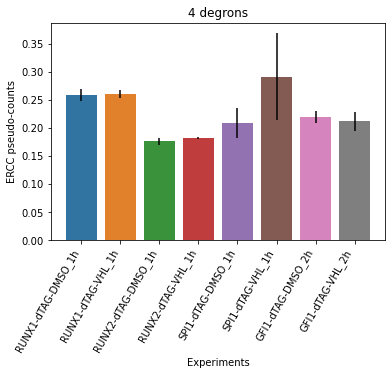

Saved to ../results/slamseq_4_degrons_v1/plots/4_degrons_v1_scaling_fact_with_conf.pdf


<Figure size 432x288 with 0 Axes>

In [179]:
version = project.replace("_", " ").split(" ")[-1]
print(version)
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None,)
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])
plt.show()

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

## Saving the data in our bucket

In [184]:
print(project)

4_degrons_v1


In [6]:
! ls ../../data/slamseq_$project

fastqs	res


In [ ]:
! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file:/

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R1_001.fa

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Resuming upload for file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_val_2.fq.gz
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Resuming upload for file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file

In [128]:
bam_files = ! ls ../../data/IRF2BP2_degraded_YKL_v1/res_v3/filter/mr*.bam

for bam in bam_files:
    print(os.path.basename(bam).split(".")[0])

mr371-MV411-IRF2BP2-dTAG-DMSO_3h-r1_filtered
mr372-MV411-IRF2BP2-dTAG-DMSO_3h-r2_filtered
mr373-MV411-IRF2BP2-dTAG-DMSO_3h-r3_filtered
mr374-MV411-IRF2BP2-dTAG-DMSO_3h-r4_filtered
mr375-MV411-IRF2BP2-dTAG-VHL_3h-r1_filtered
mr376-MV411-IRF2BP2-dTAG-VHL_3h-r2_filtered
mr377-MV411-IRF2BP2-dTAG-VHL_3h-r3_filtered
mr378-MV411-IRF2BP2-dTAG-VHL_3h-r4_filtered
mr379-MV411-IRF2BP2-dTAG-DMSO_6h-r1_filtered
mr380-MV411-IRF2BP2-dTAG-DMSO_6h-r2_filtered
mr381-MV411-IRF2BP2-dTAG-DMSO_6h-r3_filtered
mr382-MV411-IRF2BP2-dTAG-DMSO_6h-r4_filtered
mr383-MV411-IRF2BP2-dTAG-VHL_6h-r1_filtered
mr384-MV411-IRF2BP2-dTAG-VHL_6h-r2_filtered
mr385-MV411-IRF2BP2-dTAG-VHL_6h-r3_filtered
mr386-MV411-IRF2BP2-dTAG-VHL_6h-r4_filtered


In [167]:
res_folder = "res_v3"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/IRF2BP2_degraded_YKL_v1/res_v3/count/


In [5]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [169]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 16 files:dict_keys(['mr371-MV411-IRF2BP2-dTAG-DMSO_3h-r1_tcount', 'mr372-MV411-IRF2BP2-dTAG-DMSO_3h-r2_tcount', 'mr373-MV411-IRF2BP2-dTAG-DMSO_3h-r3_tcount', 'mr374-MV411-IRF2BP2-dTAG-DMSO_3h-r4_tcount', 'mr375-MV411-IRF2BP2-dTAG-VHL_3h-r1_tcount', 'mr376-MV411-IRF2BP2-dTAG-VHL_3h-r2_tcount', 'mr377-MV411-IRF2BP2-dTAG-VHL_3h-r3_tcount', 'mr378-MV411-IRF2BP2-dTAG-VHL_3h-r4_tcount', 'mr379-MV411-IRF2BP2-dTAG-DMSO_6h-r1_tcount', 'mr380-MV411-IRF2BP2-dTAG-DMSO_6h-r2_tcount', 'mr381-MV411-IRF2BP2-dTAG-DMSO_6h-r3_tcount', 'mr382-MV411-IRF2BP2-dTAG-DMSO_6h-r4_tcount', 'mr383-MV411-IRF2BP2-dTAG-VHL_6h-r1_tcount', 'mr384-MV411-IRF2BP2-dTAG-VHL_6h-r2_tcount', 'mr385-MV411-IRF2BP2-dTAG-VHL_6h-r3_tcount', 'mr386-MV411-IRF2BP2-dTAG-VHL_6h-r4_tcount'])
mr371-MV411-IRF2BP2-dTAG-DMSO_3h-r1
mr372-MV411-IRF2BP2-dTAG-DMSO_3h-r2
mr373-MV411-IRF2BP2-dTAG-DMSO_3h-r3
mr374-MV411-IRF2BP2-dTAG-DMSO_3h-r4
mr375-MV411-IRF2BP2-dTAG-VHL_3h-r1
mr376-MV411-IRF2BP2-dTAG-VHL_3h-r2
mr377-MV411-IRF2BP2-dTAG-VHL_3h

In [317]:
#feel like subsetting?
#readcounts = readcounts[readcounts.columns[:27]]
#tccounts = tccounts[tccounts.columns[:27]]

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## Make count files

In [15]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_4_degrons_v1/res/count/


In [16]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [17]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 35 files:dict_keys(['mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount', 'mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount', 'mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount', 'mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount', 'mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount', 'mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount', 'mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount', 'mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount', 'mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount', 'mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount', 'mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_tcount', 'mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_tcount', 'mr399-MV411-RUNX2-dTAG-VHL_1h-r1_tcount', 'mr400-MV411-RUNX2-dTAG-VHL_1h-r2_tcount', 'mr401-MV411-RUNX2-dTAG-VHL_1h-r3_tcount', 'mr402-MV411-RUNX2-dTAG-VHL_1h-r4_tcount', 'mr403-MV411-SPI1-dTAG-DMSO_1h-r1_tcount', 'mr404-MV411-SPI1-dTAG-DMSO_1h-r2_tcount', 'mr405-MV411-SPI1-dTAG-DMSO_1h-r3_tcount', 'mr406-MV411-SPI1-dTAG-DMSO_1h-r4_tcount', 'mr407-MV411-SPI1-dTAG-DMSO_1h-r5_tcount', 'mr408-MV411-SPI1-dTAG-VHL_1h-r1_tcount', 'mr409-MV411-SPI1-dTA

Check for duplicate gene rows

In [19]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [24]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)
if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

### make density plot

In [25]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
! mkdir $res_dir

../results/slamseq_4_degrons_v1/
mkdir: cannot create directory ‘../results/slamseq_4_degrons_v1/’: File exists


In [26]:
col = tccounts.columns.tolist() # sort cols
col.sort()
tccounts = tccounts[col]

In [27]:
col = readcounts.columns.tolist() # sort cols
col.sort()
readcounts = readcounts[col]

In [28]:
print(readcounts.shape)
readcounts.iloc[:2]

(16744, 35)


,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr412-MV411-SPI1-dTAG-VHL_1h-r5_tcount,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount
A2M,5,3,0,3,4,0,2,3,2,3,...,0,0,0,3,4,1,0,3,1,0
A2MP1,0,0,0,1,3,5,9,0,0,0,...,0,0,0,4,0,0,1,3,0,0


16383


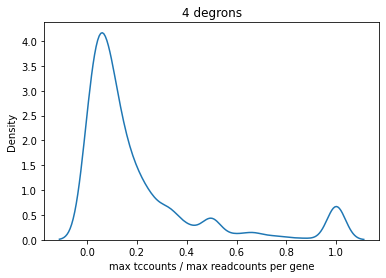

<Figure size 432x288 with 0 Axes>

In [29]:
# what is the average of highly transcribed genes
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])
plt.show()

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300)

In [31]:
np.median(a)

0.10672358591248667

In [33]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_4_degrons_v1/4_degrons_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_4_degrons_v1/4_degrons_v1_0_5_tccounts.csv


### make more df (mean, median, etc.)

In [34]:
readcounts.iloc[:1]

,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr412-MV411-SPI1-dTAG-VHL_1h-r5_tcount,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount
A2M,5,3,0,3,4,0,2,3,2,3,...,0,0,0,3,4,1,0,3,1,0


In [52]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("MV411-")[1].split("_")[0] +": "+ str(readcounts[column].idxmax()))

Genes with highest read counts per sample.
RUNX1-dTAG-DMSO: RPL13AP5
RUNX1-dTAG-DMSO: RPL13AP5
RUNX1-dTAG-DMSO: ACTG1
RUNX1-dTAG-DMSO: RPL13AP5
RUNX1-dTAG-VHL: RPL13AP5
RUNX1-dTAG-VHL: ACTG1
RUNX1-dTAG-VHL: RPL13AP5
RUNX1-dTAG-VHL: RPL13AP5
RUNX2-dTAG-DMSO: ACTG1
RUNX2-dTAG-DMSO: RPL13AP5
RUNX2-dTAG-DMSO: RPL13AP5
RUNX2-dTAG-DMSO: MALAT1
RUNX2-dTAG-VHL: RPL13AP5
RUNX2-dTAG-VHL: MALAT1
RUNX2-dTAG-VHL: RPL13AP5
RUNX2-dTAG-VHL: RPL13AP5
SPI1-dTAG-DMSO: ACTB
SPI1-dTAG-DMSO: MALAT1
SPI1-dTAG-DMSO: ACTB
SPI1-dTAG-DMSO: MALAT1
SPI1-dTAG-DMSO: ACTB
SPI1-dTAG-VHL: ACTB
SPI1-dTAG-VHL: ACTB
SPI1-dTAG-VHL: MALAT1
SPI1-dTAG-VHL: MALAT1
SPI1-dTAG-VHL: ACTB
GFI1-dTAG-DMSO: MALAT1
GFI1-dTAG-DMSO: ACTG1
GFI1-dTAG-DMSO: MALAT1
GFI1-dTAG-DMSO: MALAT1
GFI1-dTAG-DMSO: MALAT1
GFI1-dTAG-VHL: ACTG1
GFI1-dTAG-VHL: ACTG1
GFI1-dTAG-VHL: ACTG1
GFI1-dTAG-VHL: ACTG1


In [63]:
[column.split("MV411-")[1].split("-r")[0] for column in readcounts.columns]

['RUNX1-dTAG-DMSO_1h',
 'RUNX1-dTAG-DMSO_1h',
 'RUNX1-dTAG-DMSO_1h',
 'RUNX1-dTAG-DMSO_1h',
 'RUNX1-dTAG-VHL_1h',
 'RUNX1-dTAG-VHL_1h',
 'RUNX1-dTAG-VHL_1h',
 'RUNX1-dTAG-VHL_1h',
 'RUNX2-dTAG-DMSO_1h',
 'RUNX2-dTAG-DMSO_1h',
 'RUNX2-dTAG-DMSO_1h',
 'RUNX2-dTAG-DMSO_1h',
 'RUNX2-dTAG-VHL_1h',
 'RUNX2-dTAG-VHL_1h',
 'RUNX2-dTAG-VHL_1h',
 'RUNX2-dTAG-VHL_1h',
 'SPI1-dTAG-DMSO_1h',
 'SPI1-dTAG-DMSO_1h',
 'SPI1-dTAG-DMSO_1h',
 'SPI1-dTAG-DMSO_1h',
 'SPI1-dTAG-DMSO_1h',
 'SPI1-dTAG-VHL_1h',
 'SPI1-dTAG-VHL_1h',
 'SPI1-dTAG-VHL_1h',
 'SPI1-dTAG-VHL_1h',
 'SPI1-dTAG-VHL_1h',
 'GFI1-dTAG-DMSO_2h',
 'GFI1-dTAG-DMSO_2h',
 'GFI1-dTAG-DMSO_2h',
 'GFI1-dTAG-DMSO_2h',
 'GFI1-dTAG-DMSO_2h',
 'GFI1-dTAG-VHL_2h',
 'GFI1-dTAG-VHL_2h',
 'GFI1-dTAG-VHL_2h',
 'GFI1-dTAG-VHL_2h']

In [64]:
print(set([i.split('-')[-2] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])

{'VHL_2h', 'DMSO_2h', 'DMSO_1h', 'VHL_1h'}
['mr387', 'MV411-RUNX1-dTAG-DMSO_1h-r1_tcount']
MV411-RUNX1-dTAG-DMSO_1h


{'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-VHL_2h',
 'MV411-RUNX1-dTAG-DMSO_1h',
 'MV411-RUNX1-dTAG-VHL_1h',
 'MV411-RUNX2-dTAG-DMSO_1h',
 'MV411-RUNX2-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-VHL_1h'}

In [69]:
tccounts[[v for v in tccounts.columns if "MV411-RUNX1-dTAG-DMSO_1h" in v]].mean(1)

A2M              0.00
A2MP1            0.00
NAT1             6.25
AAMP            17.00
AARS1           16.25
                ...  
106736475       13.50
GET1-SH3BGR      0.00
BOLA2-SMG1P6     3.50
107303344        5.50
SCARNA18B        0.75
Length: 16744, dtype: float64

In [74]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-RUNX1-dTAG-DMSO_1h
MV411-RUNX1-dTAG-VHL_1h
MV411-RUNX2-dTAG-DMSO_1h
MV411-RUNX2-dTAG-VHL_1h
MV411-SPI1-dTAG-DMSO_1h
MV411-SPI1-dTAG-VHL_1h
MV411-GFI1-dTAG-DMSO_2h
MV411-GFI1-dTAG-VHL_2h


In [73]:
# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

In [75]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-RUNX1-dTAG-DMSO_1h
MV411-RUNX1-dTAG-VHL_1h
MV411-RUNX2-dTAG-DMSO_1h
MV411-RUNX2-dTAG-VHL_1h
MV411-SPI1-dTAG-DMSO_1h
MV411-SPI1-dTAG-VHL_1h
MV411-GFI1-dTAG-DMSO_2h
MV411-GFI1-dTAG-VHL_2h


In [79]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr412-MV411-SPI1-dTAG-VHL_1h-r5_tcount,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
A2MP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_4_degrons_v1/4_degrons_v1_0_5_tccounts_per_readcounts.csv


## Look at similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [84]:
mkdir ../results/slamseq_$project/plots/

mkdir: cannot create directory ‘../results/slamseq_4_degrons_v1/plots/’: File exists


In [86]:
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-RUNX1-dTAG-DMSO_1h',
 'MV411-RUNX1-dTAG-DMSO_1h',
 'MV411-RUNX1-dTAG-DMSO_1h',
 'MV411-RUNX1-dTAG-DMSO_1h',
 'MV411-RUNX1-dTAG-VHL_1h',
 'MV411-RUNX1-dTAG-VHL_1h',
 'MV411-RUNX1-dTAG-VHL_1h',
 'MV411-RUNX1-dTAG-VHL_1h',
 'MV411-RUNX2-dTAG-DMSO_1h',
 'MV411-RUNX2-dTAG-DMSO_1h',
 'MV411-RUNX2-dTAG-DMSO_1h',
 'MV411-RUNX2-dTAG-DMSO_1h',
 'MV411-RUNX2-dTAG-VHL_1h',
 'MV411-RUNX2-dTAG-VHL_1h',
 'MV411-RUNX2-dTAG-VHL_1h',
 'MV411-RUNX2-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-DMSO_1h',
 'MV411-SPI1-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-VHL_1h',
 'MV411-SPI1-dTAG-VHL_1h',
 'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-DMSO_2h',
 'MV411-GFI1-dTAG-VHL_2h',
 'MV411-GFI1-dTAG-VHL_2h',
 'MV411-GFI1-dTAG-VHL_2h',
 'MV411-GFI1-dTAG-VHL_2h']

In [89]:
[i.rpartition("_")[0] for i in tccounts.columns.tolist()] # name without _tccount
#tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0]
[i.split("-")[-2] for i in tccounts.columns] # conditions

['DMSO_3h',
 'DMSO_3h',
 'DMSO_3h',
 'DMSO_3h',
 'VHL_3h',
 'VHL_3h',
 'VHL_3h',
 'VHL_3h',
 'DMSO_6h',
 'DMSO_6h',
 'DMSO_6h',
 'DMSO_6h',
 'VHL_6h',
 'VHL_6h',
 'VHL_6h',
 'VHL_6h']

### save plots to pdf

Replicate similarity plot saved to: ../results/slamseq_4_degrons_v1/plots/4_degrons_v1_similarity_replicates_sorted_tccounts.pdf


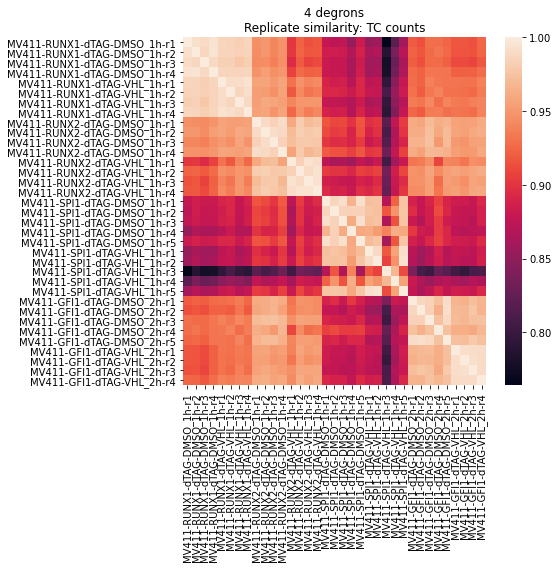

In [98]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    #"sans-serif" : "Arial",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(), 
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns], # condition w/ rep label
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_4_degrons_v1/plots/4_degrons_v1_similarity_replicates_sorted_readcounts.pdf


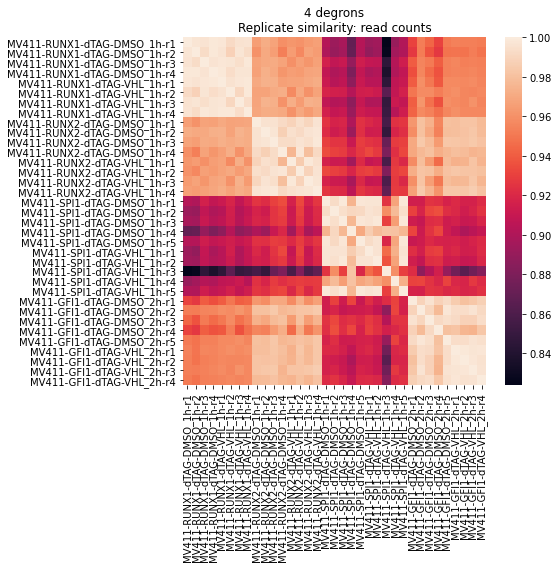

In [102]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in readcounts.columns], # condition w/ replicate
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in readcounts.columns],
            ax=ax)#, cmap=cmp_cylin), vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESEQ Analysis

In [275]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_4_degrons_v1/


In [110]:
readcounts.iloc[:3]

,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr412-MV411-SPI1-dTAG-VHL_1h-r5_tcount,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount
A2M,5,3,0,3,4,0,2,3,2,3,...,0,0,0,3,4,1,0,3,1,0
A2MP1,0,0,0,1,3,5,9,0,0,0,...,0,0,0,4,0,0,1,3,0,0
NAT1,86,114,63,144,63,89,125,91,79,129,...,217,105,111,116,225,144,86,166,147,135


In [111]:
readcounts["genes"] = readcounts.index # make genes col
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [149]:
readcounts.iloc[:1]

,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount,genes
0,5,3,0,3,4,0,2,3,2,3,...,0,0,3,4,1,0,3,1,0,A2M


In [148]:
tccounts.iloc[:1]

,mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount,mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount,mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount,mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount,mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount,mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount,mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount,mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount,mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount,mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount,...,mr413-MV411-GFI1-dTAG-DMSO_2h-r1_tcount,mr414-MV411-GFI1-dTAG-DMSO_2h-r2_tcount,mr415-MV411-GFI1-dTAG-DMSO_2h-r3_tcount,mr416-MV411-GFI1-dTAG-DMSO_2h-r4_tcount,mr417-MV411-GFI1-dTAG-DMSO_2h-r5_tcount,mr418-MV411-GFI1-dTAG-VHL_2h-r1_tcount,mr419-MV411-GFI1-dTAG-VHL_2h-r2_tcount,mr420-MV411-GFI1-dTAG-VHL_2h-r3_tcount,mr421-MV411-GFI1-dTAG-VHL_2h-r4_tcount,genes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,A2M


## RUNX1

### make design matrix

In [323]:
# RUNX1 dTAG
gene = "RUNX1"
version = "v1"
cond = [i for i in tccounts.columns.tolist() if gene in i][0].split("_")[-2].split("-")[0]
cond

In [249]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]] # readcounts

In [250]:
gene_cols = [1 if gene in col else 0 for col in tccountsGene.columns.tolist()] # get just gene
DMSO_cols = [1 if gene in col and "DMSO" in col else 0 for col in tccountsGene.columns.tolist()]
VHL_cols = [1 if gene in col and "VHL" in col else 0 for col in tccountsGene.columns.tolist()]

In [251]:
# RUNX1 dTAG (all columns)
designGene = pd.DataFrame(index= [i.replace('-','.') for i in tccountsGene.columns], 
                         columns=['DMSO','VHL'], 
                         data=np.array([DMSO_cols, VHL_cols],dtype=bool).T)

In [256]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [324]:
scaling="ERCCsamplewise"

#### make DESeq object

In [269]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                 design_matrix=designGene[np.array(gene_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [270]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                   design_matrix=designGene[np.array(gene_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [271]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGenes.columns[[False]+designGene["DMSO"]]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [277]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)
res = res.filter(like=gene) # get gene values
res

0
ERCC_mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_filtered.bam    0.265507
ERCC_mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_filtered.bam    0.269511
ERCC_mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_filtered.bam    0.257845
ERCC_mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_filtered.bam    0.242009
ERCC_mr391-MV411-RUNX1-dTAG-VHL_1h-r1_filtered.bam     0.254056
ERCC_mr392-MV411-RUNX1-dTAG-VHL_1h-r2_filtered.bam     0.268483
ERCC_mr393-MV411-RUNX1-dTAG-VHL_1h-r3_filtered.bam     0.267883
ERCC_mr394-MV411-RUNX1-dTAG-VHL_1h-r4_filtered.bam     0.251121
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [281]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [282]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [283]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.22 s, sys: 844 ms, total: 7.06 s
Wall time: 5.16 s


In [284]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.2 s, sys: 1.86 s, total: 10.1 s
Wall time: 6.03 s


#### save DESeq results

In [320]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [321]:
# tccounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX1_1h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [322]:
# readcounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX1_1h_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [331]:
scaling = None

#### make DESeq object

In [332]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                 design_matrix=designGene[np.array(gene_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [333]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                   design_matrix=designGene[np.array(gene_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [335]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGenes.columns[[False]+designGene["DMSO"]]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [336]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.07 s, sys: 912 ms, total: 6.98 s
Wall time: 5.04 s


In [337]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.63 s, sys: 1.78 s, total: 9.41 s
Wall time: 5.57 s


#### save DESeq results

In [338]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [340]:
# tccounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX1_1h_0_5_deseq_tccounts.csv


In [342]:
# readcounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX1_1h_0_5_deseq_readcounts.csv


## RUNX2

### make design matrix

In [345]:
# RUNX2 dTAG
gene = "RUNX2"
version = "v1"
cond = [i for i in tccounts.columns.tolist() if gene in i][0].split("_")[-2].split("-")[0]
cond

In [347]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]] # readcounts

In [348]:
gene_cols = [1 if gene in col else 0 for col in tccountsGene.columns.tolist()] # get just gene
DMSO_cols = [1 if gene in col and "DMSO" in col else 0 for col in tccountsGene.columns.tolist()]
VHL_cols = [1 if gene in col and "VHL" in col else 0 for col in tccountsGene.columns.tolist()]

In [349]:
# all columns
designGene = pd.DataFrame(index= [i.replace('-','.') for i in tccountsGene.columns], 
                         columns=['DMSO','VHL'], 
                         data=np.array([DMSO_cols, VHL_cols],dtype=bool).T)

In [351]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [352]:
scaling="ERCCsamplewise"

#### make DESeq object

In [353]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                 design_matrix=designGene[np.array(gene_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [354]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                   design_matrix=designGene[np.array(gene_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [355]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGenes.columns[[False]+designGene["DMSO"]]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [357]:
# read in ERCC pseudocounts
res = pd.read_csv("../results/slamseq_{0}/{0}_scaling_factors.csv".format(project), index_col=0, header=None, squeeze=True)
res = res.filter(like=gene) # get gene values
res

0
ERCC_mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_filtered.bam    0.176800
ERCC_mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_filtered.bam    0.166558
ERCC_mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_filtered.bam    0.178445
ERCC_mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_filtered.bam    0.182913
ERCC_mr399-MV411-RUNX2-dTAG-VHL_1h-r1_filtered.bam     0.183372
ERCC_mr400-MV411-RUNX2-dTAG-VHL_1h-r2_filtered.bam     0.181594
ERCC_mr401-MV411-RUNX2-dTAG-VHL_1h-r3_filtered.bam     0.183376
ERCC_mr402-MV411-RUNX2-dTAG-VHL_1h-r4_filtered.bam     0.178930
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [358]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [359]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [360]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.92 s, sys: 1.04 s, total: 7.96 s
Wall time: 5.74 s


In [361]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.14 s, sys: 1.89 s, total: 10 s
Wall time: 6.01 s


#### save DESeq results

In [362]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [363]:
# tccounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX2_1h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [364]:
# readcounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX2_1h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [365]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,6.856393,-0.349339,0.607023,0.575496,0.564956,NaN,NAT1,NAT1
3,30.739513,0.270486,0.288293,-0.938234,0.348124,0.633322,AAMP,AAMP
4,22.390773,0.266391,0.319677,-0.833312,0.404669,NaN,AARS1,AARS1


In [366]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.168326,0.113840,0.946798,-0.120237,0.904295,NaN,A2M,A2M
1,0.986161,2.369922,1.588698,-1.491739,0.135768,NaN,A2MP1,A2MP1
2,82.351962,-0.272783,0.192600,1.416315,0.156683,NaN,NAT1,NAT1
3,838.944102,0.027372,0.092726,-0.295190,0.767848,0.892526,AAMP,AAMP
4,810.419023,-0.042175,0.085978,0.490530,0.623759,0.807891,AARS1,AARS1


### Unscaled

In [367]:
scaling = None

#### make DESeq object

In [368]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                 design_matrix=designGene[np.array(gene_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [369]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+gene_cols, bool)]], 
                                   design_matrix=designGene[np.array(gene_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [370]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGenes.columns[[False]+designGene["DMSO"]]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [371]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.36 s, sys: 864 ms, total: 7.22 s
Wall time: 5.22 s


In [372]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.97 s, sys: 1.82 s, total: 9.79 s
Wall time: 5.93 s


#### save DESeq results

In [373]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [374]:
# tccounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX2_1h_0_5_deseq_tccounts.csv


In [375]:
# readcounts
res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, cond, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: 4_degrons_v1_RUNX2_1h_0_5_deseq_readcounts.csv


In [376]:
resGene_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,6.951306,-0.303572,0.605646,0.501238,0.616204,NaN,NAT1,NAT1
3,31.259611,0.315536,0.286878,-1.099897,0.271377,0.575906,AAMP,AAMP
4,22.773227,0.311411,0.318495,-0.977758,0.328194,NaN,AARS1,AARS1


In [377]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.205886,0.159509,0.943860,-0.168996,0.865800,NaN,A2M,A2M
1,1.016176,2.419807,1.582256,-1.529340,0.126180,NaN,A2MP1,A2MP1
2,83.505223,-0.228406,0.191016,1.195739,0.231799,0.581545,NAT1,NAT1
3,852.644062,0.073201,0.093655,-0.781607,0.434446,0.723439,AAMP,AAMP
4,823.189291,0.003217,0.085388,-0.037679,0.969943,0.985477,AARS1,AARS1


# PLOTS

### whisker's plots

#### Get CRCs

In [107]:
crc = pd.read_csv('../data/CRCs.txt',header=None)[0].values.tolist()
print(len(crc))
print(crc)

31
['CEBPA', 'E2F3', 'FLI1', 'FOSL2', 'GFI1', 'HEX', 'IRF8', 'LYL1', 'MEF2C', 'MEF2D', 'MEIS1', 'MYB', 'PLAGL2', 'RUNX1', 'RUNX2', 'RXRA', 'SP1', 'SPI1', 'SREBF1', 'STAT5B', 'TFAP4', 'ZEB2', 'ZFPM1', 'ZNF281', 'LMO2', 'ZMYND8', 'GATA2', 'MAX', 'MYC', 'ETV6', 'HOXA9']


#### IRF2BP2 3h

In [108]:
%matplotlib inline

In [129]:
resIRF2BP2_3h.baseMean.quantile([0,0.45,0.5,0.75,1])

0.00       0.000000
0.45       3.688175
0.50       5.281572
0.75      23.078801
1.00    1897.717965
Name: baseMean, dtype: float64

In [130]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resIRF2BP2_3h[resIRF2BP2_3h.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
1,3.958770,0.315619,0.385422,-0.818892,0.412848,0.644171,AAMP,AAMP,other
2,4.091240,-0.109872,0.395827,0.277577,0.781337,0.885655,AARS1,AARS1,other
9,6.272265,0.145858,0.179321,-0.813392,0.415993,0.646127,ABL1,ABL1,other
11,6.012306,-0.569955,0.204069,2.792953,0.005223,0.059727,ABL2,ABL2,other
12,4.078594,0.579548,0.353195,-1.640874,0.100823,0.299090,ABR,ABR,other


Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_3h_logfch.pdf


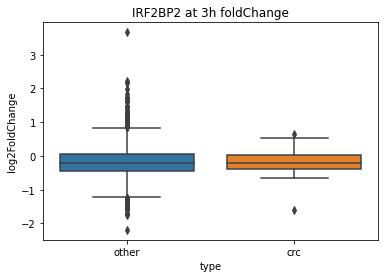

In [131]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("IRF2BP2 at 3h foldChange")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_3h_logfch.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_3h_baseMean.pdf


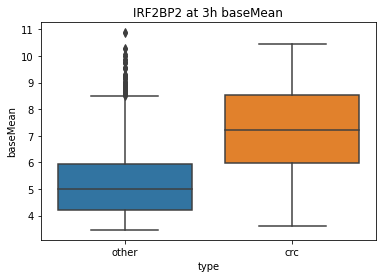

In [132]:
ax =sns.boxplot(data=res,x='type',y='baseMean').set_title("IRF2BP2 at 3h baseMean")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_3h_baseMean.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

#### IRF2BP2 6h

In [123]:
resIRF2BP2_6h.baseMean.quantile([0,0.45,0.5,0.75,1])

0.00      0.000000
0.45      1.502293
0.50      2.125793
0.75      8.618345
1.00    792.305610
Name: baseMean, dtype: float64

In [124]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resIRF2BP2_6h[resIRF2BP2_6h.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,3.567919,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1,other
9,4.759121,-0.802452,0.347349,2.310216,0.020876,0.931416,ABL1,ABL1,other
11,4.425603,-0.300262,0.394766,0.760606,0.446892,0.997053,ABL2,ABL2,other
22,4.141529,-0.134999,0.438179,0.308091,0.758013,0.997053,ACLY,ACLY,other
26,4.286644,-0.203152,0.398038,0.510383,0.609783,0.997053,ACP1,ACP1,other


Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_logfch.pdf


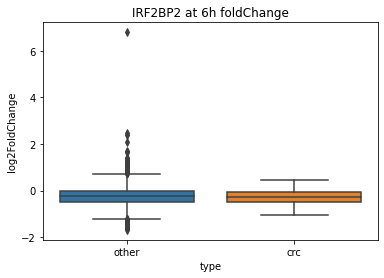

In [125]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("IRF2BP2 at 6h foldChange")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_logfch.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_baseMean.pdf


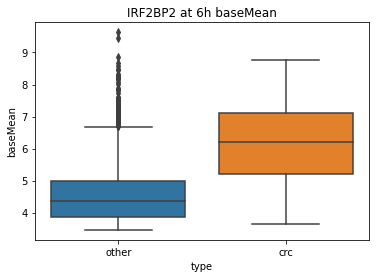

In [128]:
ax =sns.boxplot(data=res,x='type',y='baseMean').set_title("IRF2BP2 at 6h baseMean")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_baseMean.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

## Scatter plot comparison

#### IRF2BP2 3h vs 6h

In [133]:
mix = pd.DataFrame()
mix["gene_id"] = resIRF2BP2_3h["gene_id"]
mix['IRF2BP2 3h'] = resIRF2BP2_3h.log2FoldChange
mix['IRF2BP2 6h'] = resIRF2BP2_6h.log2FoldChange

In [135]:
print(mix.shape)
mix.head()

(15139, 3)


,gene_id,IRF2BP2 3h,IRF2BP2 6h
0,NAT1,-0.556462,1.835873
1,AAMP,0.315619,0.117255
2,AARS1,-0.109872,-0.073534
3,ABAT,-0.946852,-1.138852
4,ABCA1,-0.439957,-1.167510


In [143]:
scatter_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(scatter_folder)


genepyPlot.scatter(mix[['IRF2BP2 3h', 'IRF2BP2 6h']].values[:12000],
                   mix['gene_id'].values.tolist()[:12000], radi= 0.06, alpha=0.3,
                   colors = [0 if i in crc else 1 for i in mix['gene_id'].values.tolist()[:12000]],
                   xname="IRF2BP2 3h", yname="IRF2BP2 6h",
                   folder=scatter_folder,
                   title='IRF2BP2 3h vs 6h differences in logFoldChange')

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5


Figure(id='2237', ...)

## Regular volcanos

In [163]:
from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

#### IRF2BP2 3h

In [144]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_3h_deseq.csv'
resIRF2BP2_3h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_3h_deseq.csv


In [146]:
resIRF2BP2_3h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,5.019967,-0.556462,0.738811,0.753185,0.451339,NaN,NAT1,NAT1
1,14.549214,0.315619,0.385422,-0.818892,0.412848,0.644171,AAMP,AAMP
2,16.044563,-0.109872,0.395827,0.277577,0.781337,0.885655,AARS1,AARS1
3,1.695828,-0.946852,1.260507,0.751167,0.452552,NaN,ABAT,ABAT
4,6.332239,-0.439957,0.569045,0.773150,0.439434,NaN,ABCA1,ABCA1


In [165]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_3h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 3h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_3h_volcano.html


Column(id='6969', ...)

#### IRF2BP2 6h

In [145]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_6h_deseq.csv'
resIRF2BP2_6h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_6h_deseq.csv


In [147]:
resIRF2BP2_6h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.679474,1.835873,1.882485,-0.975239,0.329442,0.997053,NAT1,NAT1
1,6.895730,0.117255,0.620358,-0.189013,0.850083,0.997053,AAMP,AAMP
2,10.859066,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1
3,0.633716,-1.138852,2.091871,0.544418,0.586154,0.997053,ABAT,ABAT
4,1.383080,-1.167510,1.382278,0.844627,0.398319,0.997053,ABCA1,ABCA1


In [164]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
#volcano_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_6h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 6h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_6h_volcano.html


Column(id='6539', ...)